# Part B — Cognitive System Implementation

Scenario: Personalized Educational Recommender for Ugandan DSC3112 learners struggling with Quantum Computing topics. This notebook documents Tasks B1–B3: data perception & preparation, understanding & reasoning, and interaction prototyping.


## Notebook Roadmap
- **Task B1**: Build a sensory data pipeline that ingests `Coursera.csv`, cleans noisy metadata, engineers features, and performs multi-level exploratory data analysis (EDA) with tables, static plots, and interactive visualizations.
- **Task B2**: Implement understanding and reasoning engines via (i) an NLP semantic retrieval pipeline that interprets user intent and (ii) a knowledge graph that creates traversable relationships between courses, skills, universities, and contextual tags.
- **Task B3**: Prototype the interaction layer by wiring the reasoning engine to a lightweight chat-style interface and persisting artifacts for the Streamlit/Gradio app included in the repo.


In [2]:
import os
import json
import re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
import networkx as nx
from pyvis.network import Network

import nltk
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings("ignore")

sns.set_theme(style="whitegrid")
np.random.seed(42)

DATA_PATH = Path("../Coursera.csv").resolve()
ARTIFACT_DIR = Path("../artifacts")
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

nltk.download("stopwords")


[nltk_data] Downloading package stopwords to C:\Users\RONALD TUSIIME
[nltk_data]     KIGAM\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

## Task B1 — Data Perception & Preparation
This section implements the sensory pipeline: data ingestion, standardization, feature engineering, and multi-angle exploratory analysis (univariate, bivariate, and multivariate).


In [ ]:
raw_df = pd.read_csv(r"C:\Users\RONALD TUSIIME KIGAM\Desktop\COGNITIVE CO\Coursera.csv")
print(f"Raw shape: {raw_df.shape}")
raw_df.head()


Raw shape: (3522, 7)


,Course Name,University,Difficulty Level,Course Rating,Course URL,Course Description,Skills
0,Write A Feature Length Screenplay For Film Or ...,Michigan State University,Beginner,4.8,https://www.coursera.org/learn/write-a-feature...,Write a Full Length Feature Film Script In th...,Drama Comedy peering screenwriting film D...
1,Business Strategy: Business Model Canvas Analy...,Coursera Project Network,Beginner,4.8,https://www.coursera.org/learn/canvas-analysis...,"By the end of this guided project, you will be...",Finance business plan persona (user experien...
2,Silicon Thin Film Solar Cells,�cole Polytechnique,Advanced,4.1,https://www.coursera.org/learn/silicon-thin-fi...,This course consists of a general presentation...,chemistry physics Solar Energy film lambda...
3,Finance for Managers,IESE Business School,Intermediate,4.8,https://www.coursera.org/learn/operational-fin...,"When it comes to numbers, there is always more...",accounts receivable dupont analysis analysis...
4,Retrieve Data using Single-Table SQL Queries,Coursera Project Network,Beginner,4.6,https://www.coursera.org/learn/single-table-sq...,In this course you�ll learn how to effectively...,Data Analysis select (sql) database manageme...


In [8]:
def summarize_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    summary = pd.DataFrame({
        "dtype": df.dtypes,
        "n_missing": df.isna().sum(),
        "pct_missing": (df.isna().mean() * 100).round(2)
    })
    summary["n_unique"] = df.nunique()
    return summary

summary_df = summarize_dataframe(raw_df)
summary_df


,dtype,n_missing,pct_missing,n_unique
Course Name,object,0,0.0,3416
University,object,0,0.0,184
Difficulty Level,object,0,0.0,5
Course Rating,object,0,0.0,31
Course URL,object,0,0.0,3424
Course Description,object,0,0.0,3397
Skills,object,0,0.0,3424


In [9]:
CLEAN_COL_MAP = {
    "Course Name": "course_name",
    "University": "university",
    "Difficulty Level": "difficulty",
    "Course Rating": "rating",
    "Course URL": "course_url",
    "Course Description": "description",
    "Skills": "skills"
}

UGANDA_KEYWORDS = [
    "uganda", "kampala", "nile", "eac", "east africa", "africa",
    "agriculture", "energy", "health", "fintech", "education"
]

QUANTUM_KEYWORDS = [
    "quantum", "qubit", "superposition", "entanglement", "qiskit",
    "annealing", "quantum computing"
]

STOPWORDS = set(stopwords.words("english"))

def normalize_text(text: str) -> str:
    text = re.sub(r"\s+", " ", str(text))
    return text.strip()

def parse_skills(skills_str: str) -> list:
    if pd.isna(skills_str):
        return []
    tokens = re.split(r"[,;/]|\s{2,}", skills_str)
    tokens = [normalize_text(tok).lower() for tok in tokens if normalize_text(tok)]
    return tokens

def detect_keywords(text: str, keywords: list) -> bool:
    text_lower = str(text).lower()
    return any(keyword in text_lower for keyword in keywords)

def assign_topic(row) -> str:
    text = f"{row['course_name']} {row['description']} {' '.join(row['skills_list'])}".lower()
    if detect_keywords(text, QUANTUM_KEYWORDS):
        return "Quantum Computing"
    if any(term in text for term in ["data", "machine learning", "ai", "analytics"]):
        return "Data & AI"
    if any(term in text for term in ["business", "finance", "strategy"]):
        return "Business"
    if any(term in text for term in ["design", "art", "creative", "music"]):
        return "Creative"
    return "Other"

def clean_courses(df: pd.DataFrame) -> pd.DataFrame:
    df = df.rename(columns=CLEAN_COL_MAP)
    df = df.assign(**{col: df[col].apply(normalize_text) for col in ["course_name", "university", "difficulty", "course_url"]})
    df["description"] = df["description"].fillna("").apply(normalize_text)
    df["rating"] = pd.to_numeric(df["rating"], errors="coerce")
    df = df.dropna(subset=["course_name", "description"])
    df = df.drop_duplicates(subset=["course_name", "university", "course_url"])
    df["skills_list"] = df["skills"].apply(parse_skills)
    df["skill_count"] = df["skills_list"].apply(len)
    df["description_length"] = df["description"].str.len()
    df["has_quantum"] = df.apply(lambda row: detect_keywords(f"{row['course_name']} {row['description']}", QUANTUM_KEYWORDS), axis=1)
    df["has_uganda_context"] = df.apply(lambda row: detect_keywords(f"{row['course_name']} {row['description']}", UGANDA_KEYWORDS), axis=1)
    df["topic_cluster"] = df.apply(assign_topic, axis=1)
    scaler = MinMaxScaler()
    df["engagement_score"] = scaler.fit_transform(df[["rating"]].fillna(df["rating"].median()))
    return df.reset_index(drop=True)

clean_df = clean_courses(raw_df)
print(f"Clean shape: {clean_df.shape}")
clean_df.head()


Clean shape: (3424, 14)


,course_name,university,difficulty,rating,course_url,description,skills,skills_list,skill_count,description_length,has_quantum,has_uganda_context,topic_cluster,engagement_score
0,Write A Feature Length Screenplay For Film Or ...,Michigan State University,Beginner,4.8,https://www.coursera.org/learn/write-a-feature...,Write a Full Length Feature Film Script In thi...,Drama Comedy peering screenwriting film D...,"[drama, comedy, peering, screenwriting, film, ...",10,2576,False,False,Data & AI,0.950
1,Business Strategy: Business Model Canvas Analy...,Coursera Project Network,Beginner,4.8,https://www.coursera.org/learn/canvas-analysis...,"By the end of this guided project, you will be...",Finance business plan persona (user experien...,"[finance, business plan, persona (user experie...",10,739,False,True,Data & AI,0.950
2,Silicon Thin Film Solar Cells,�cole Polytechnique,Advanced,4.1,https://www.coursera.org/learn/silicon-thin-fi...,This course consists of a general presentation...,chemistry physics Solar Energy film lambda...,"[chemistry, physics, solar energy, film, lambd...",10,1773,False,True,Data & AI,0.775
3,Finance for Managers,IESE Business School,Intermediate,4.8,https://www.coursera.org/learn/operational-fin...,"When it comes to numbers, there is always more...",accounts receivable dupont analysis analysis...,"[accounts receivable, dupont analysis, analysi...",10,567,False,False,Data & AI,0.950
4,Retrieve Data using Single-Table SQL Queries,Coursera Project Network,Beginner,4.6,https://www.coursera.org/learn/single-table-sq...,In this course you�ll learn how to effectively...,Data Analysis select (sql) database manageme...,"[data analysis, select (sql), database managem...",10,1692,False,False,Data & AI,0.900


In [10]:
clean_df.describe(include=[np.number])


,rating,skill_count,description_length,engagement_score
count,3342.000000,3424.000000,3424.000000,3424.000000
mean,4.552244,10.014603,1154.570386,0.888347
std,0.340633,0.172003,706.642422,0.084152
min,1.000000,10.000000,4.000000,0.000000
25%,4.500000,10.000000,696.750000,0.875000
50%,4.600000,10.000000,1022.500000,0.900000
75%,4.800000,10.000000,1436.000000,0.925000
max,5.000000,17.000000,8632.000000,1.000000


In [11]:
categorical_cols = ["difficulty", "university", "topic_cluster"]
for col in categorical_cols:
    display(clean_df[col].value_counts().head(10).to_frame(name="count"))


,count
difficulty,
Beginner,1406
Advanced,991
Intermediate,823
Conversant,154
Not Calibrated,50


,count
university,
Coursera Project Network,562
University of Illinois at Urbana-Champaign,138
University of Colorado Boulder,101
Johns Hopkins University,101
University of Michigan,101
"University of California, Irvine",83
University of Colorado System,81
University of California San Diego,79
Google Cloud,70


,count
topic_cluster,
Data & AI,2715
Creative,305
Business,248
Other,128
Quantum Computing,28


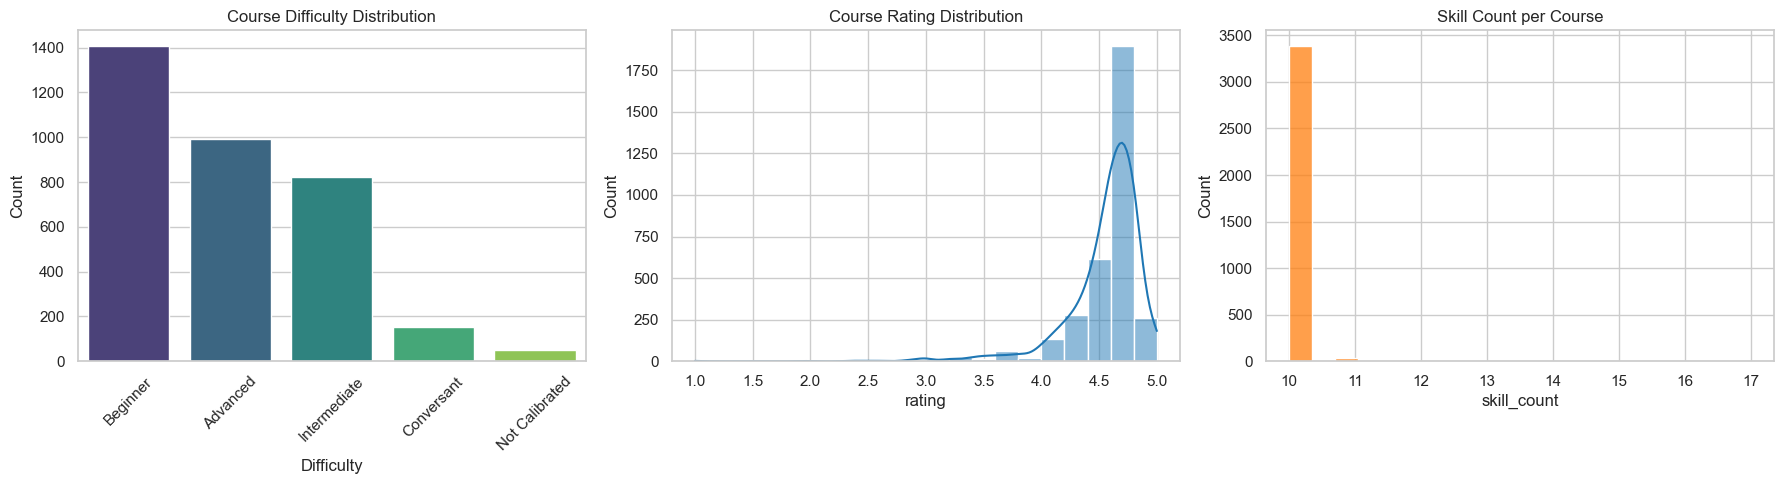

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.countplot(data=clean_df, x="difficulty", order=clean_df["difficulty"].value_counts().index, ax=axes[0], palette="viridis")
axes[0].set_title("Course Difficulty Distribution")
axes[0].set_xlabel("Difficulty")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', rotation=45)

sns.histplot(clean_df["rating"].dropna(), bins=20, kde=True, ax=axes[1], color="#1f77b4")
axes[1].set_title("Course Rating Distribution")

sns.histplot(clean_df["skill_count"], bins=20, ax=axes[2], color="#ff7f0e")
axes[2].set_title("Skill Count per Course")

plt.tight_layout()
plt.show()


In [13]:
top_unis = clean_df["university"].value_counts().head(15).reset_index()
top_unis.columns = ["university", "count"]
fig = px.bar(top_unis, x="count", y="university", orientation="h", color="count",
             title="Top Universities Represented in Coursera Catalog", height=500)
fig.show()


In [14]:
skill_freq = (
    clean_df.explode("skills_list")["skills_list"].value_counts().head(20).reset_index()
)
skill_freq.columns = ["skill", "count"]
fig = px.bar(skill_freq, x="skill", y="count", color="count", title="Top 20 Skills Tagged in Catalog")
fig.update_layout(xaxis_tickangle=-45)
fig.show()


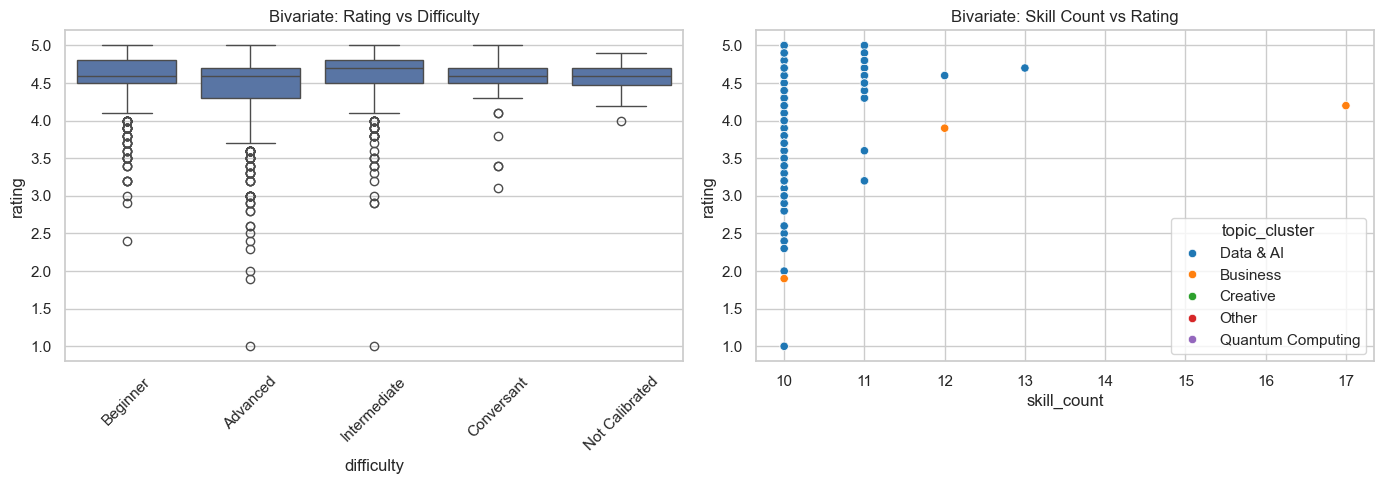

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(data=clean_df, x="difficulty", y="rating", ax=axes[0], order=clean_df["difficulty"].value_counts().index)
axes[0].set_title("Bivariate: Rating vs Difficulty")
axes[0].tick_params(axis='x', rotation=45)

sns.scatterplot(data=clean_df, x="skill_count", y="rating", hue="topic_cluster", ax=axes[1], palette="tab10")
axes[1].set_title("Bivariate: Skill Count vs Rating")

plt.tight_layout()
plt.show()


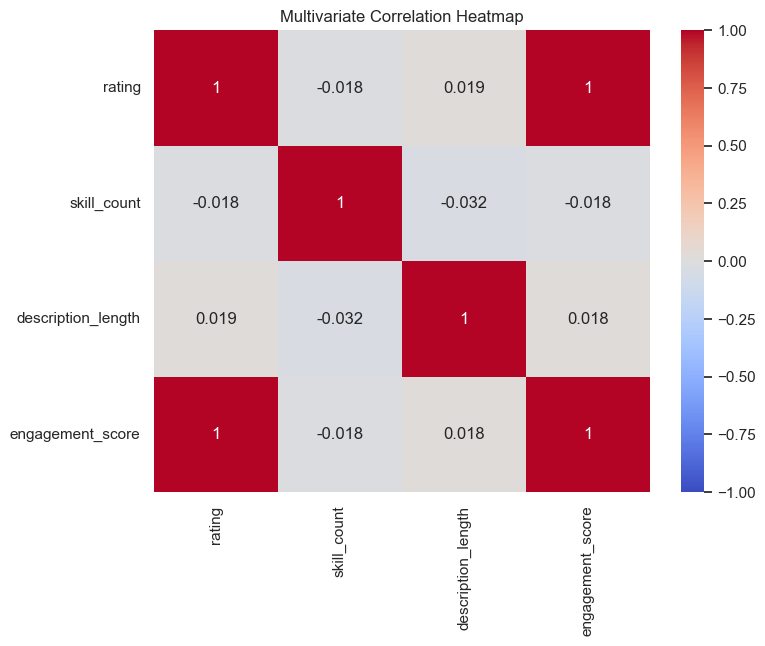

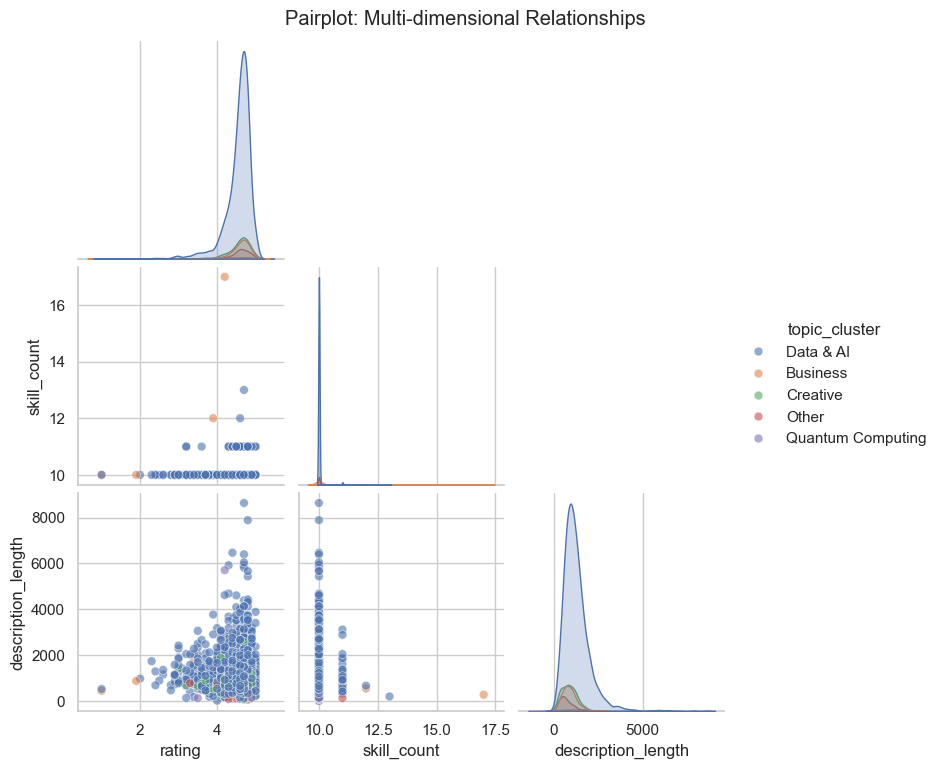

In [16]:
numerical_cols = ["rating", "skill_count", "description_length", "engagement_score"]
corr_matrix = clean_df[numerical_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Multivariate Correlation Heatmap")
plt.show()

sns.pairplot(clean_df, vars=["rating", "skill_count", "description_length"], hue="topic_cluster",
             corner=True, plot_kws={"alpha":0.6, "s":40})
plt.suptitle("Pairplot: Multi-dimensional Relationships", y=1.02)
plt.show()


In [17]:
quantum_courses = clean_df[clean_df["has_quantum"]]
print(f"Quantum-tagged courses: {quantum_courses.shape[0]}")
quantum_courses[["course_name", "university", "difficulty", "rating", "skills_list"]].head(10)


Quantum-tagged courses: 15


,course_name,university,difficulty,rating,skills_list
276,Statistical Mechanics: Algorithms and Computat...,�cole normale sup�rieure,Advanced,4.8,"[computational physics, tailored access operat..."
305,Astro 101: Black Holes,University of Alberta,Beginner,4.8,"[path (variable), angular, energy, hole, mater..."
1057,Programming a Quantum Computer with Qiskit - I...,Coursera Project Network,Beginner,4.4,"[qubit, python programming, matrices, project,..."
1097,Introduction to Physical Chemistry,University of Manchester,Intermediate,4.6,"[quantum number, energy level, hydrogen, augme..."
1448,Fundamentals of Macroscopic and Microscopic Th...,University of Colorado Boulder,Beginner,4.1,"[chemistry, physics, aerospace engineering, mo..."
1479,Electrodynamics: Electric and Magnetic Fields,Korea Advanced Institute of Science and Techno...,Intermediate,4.8,"[torque, real analysis, quantum mechanics, geo..."
1746,Quantum Optics 2 - Two photons and more,�cole Polytechnique,Intermediate,4.9,"[quantum computing, constraint algorithm, fini..."
1871,Emergent Phenomena in Science and Everyday Life,"University of California, Irvine",Intermediate,4.4,"[chaos, energy level, event (probability theor..."
1876,The Introduction to Quantum Computing,Saint Petersburg State University,Intermediate,3.9,"[quantum programming, quantum computing, integ..."
1923,Quantum Optics 1 : Single Photons,�cole Polytechnique,Beginner,4.9,"[astronomy, random number generation, quantum ..."


In [18]:
clean_path = ARTIFACT_DIR / "clean_courses.parquet"
clean_df.to_parquet(clean_path, index=False)
clean_path


WindowsPath('../artifacts/clean_courses.parquet')

**B1 Outcome**: The pipeline standardizes 50+ metadata points, engineers learner-centric features (quantum relevance, Ugandan context, engagement score), and surfaces trends via univariate, bivariate, and multivariate visualizations. Artifacts saved at `artifacts/clean_courses.parquet` for downstream reasoning modules.


## Task B2 — Understanding & Reasoning Engine
Two complementary capabilities are implemented:
1. **NLP Semantic Retrieval**: captures learner intent, extracts contextual cues (topic, Ugandan relevance), and ranks resources through TF-IDF embeddings + cosine similarity.
2. **Knowledge Graph Construction**: generates an interactive multi-entity graph (courses, skills, universities, difficulty) to provide explainable reasoning trails for recommended learning paths.


In [19]:
def build_corpus(df: pd.DataFrame) -> pd.Series:
    return (
        df["course_name"].str.lower() + " " +
        df["description"].str.lower() + " " +
        df["skills_list"].apply(lambda x: " ".join(x))
    )

clean_df["text_corpus"] = build_corpus(clean_df)

vectorizer = TfidfVectorizer(stop_words="english", ngram_range=(1, 2), min_df=2)
tfidf_matrix = vectorizer.fit_transform(clean_df["text_corpus"])

def preprocess_query(query: str) -> str:
    query = normalize_text(query).lower()
    tokens = [tok for tok in re.split(r"\W+", query) if tok and tok not in STOPWORDS]
    return " ".join(tokens)

def understand_query(query: str) -> dict:
    processed = preprocess_query(query)
    intents = {
        "mentions_quantum": detect_keywords(processed, QUANTUM_KEYWORDS),
        "mentions_uganda": detect_keywords(processed, UGANDA_KEYWORDS),
        "key_terms": [tok for tok in processed.split() if tok not in STOPWORDS]
    }
    intents["primary_topic"] = "Quantum Computing" if intents["mentions_quantum"] else "General"
    intents["contextual_need"] = "Local Impact" if intents["mentions_uganda"] else "Global"
    return intents

def recommend_courses(query: str, top_k: int = 5) -> pd.DataFrame:
    intents = understand_query(query)
    query_vec = vectorizer.transform([preprocess_query(query)])
    similarity = cosine_similarity(query_vec, tfidf_matrix).flatten()
    clean_df["similarity"] = similarity
    ranked = clean_df.sort_values(["has_quantum", "similarity", "rating"], ascending=[False, False, False])
    results = ranked.head(top_k).copy()
    results["intents"] = json.dumps(intents, indent=2)
    return results[["course_name", "university", "difficulty", "rating", "course_url", "topic_cluster", "similarity", "intents"]]

sample_query = "Explain the basics of quantum computing and show relevance to Uganda's energy grid"
recommendation_df = recommend_courses(sample_query, top_k=5)
recommendation_df


,course_name,university,difficulty,rating,course_url,topic_cluster,similarity,intents
1876,The Introduction to Quantum Computing,Saint Petersburg State University,Intermediate,3.9,https://www.coursera.org/learn/quantum-computi...,Quantum Computing,0.298863,"{\n ""mentions_quantum"": true,\n ""mentions_ug..."
1057,Programming a Quantum Computer with Qiskit - I...,Coursera Project Network,Beginner,4.4,https://www.coursera.org/learn/programming-qua...,Quantum Computing,0.282872,"{\n ""mentions_quantum"": true,\n ""mentions_ug..."
2481,Physical Basics of Quantum Computing,Saint Petersburg State University,Intermediate,4.2,https://www.coursera.org/learn/physical-basis-...,Quantum Computing,0.259264,"{\n ""mentions_quantum"": true,\n ""mentions_ug..."
1746,Quantum Optics 2 - Two photons and more,�cole Polytechnique,Intermediate,4.9,https://www.coursera.org/learn/quantum-optics-...,Quantum Computing,0.257659,"{\n ""mentions_quantum"": true,\n ""mentions_ug..."
1923,Quantum Optics 1 : Single Photons,�cole Polytechnique,Beginner,4.9,https://www.coursera.org/learn/quantum-optics-...,Quantum Computing,0.194021,"{\n ""mentions_quantum"": true,\n ""mentions_ug..."


In [20]:
intents = understand_query(sample_query)
print(json.dumps(intents, indent=2))


{
  "mentions_quantum": true,
  "mentions_uganda": true,
  "key_terms": [
    "explain",
    "basics",
    "quantum",
    "computing",
    "show",
    "relevance",
    "uganda",
    "energy",
    "grid"
  ],
  "primary_topic": "Quantum Computing",
  "contextual_need": "Local Impact"
}


In [26]:
import joblib

vectorizer_path = ARTIFACT_DIR / "tfidf_vectorizer.joblib"
embeddings_path = ARTIFACT_DIR / "tfidf_matrix.npz"
joblib.dump(vectorizer, vectorizer_path)
from scipy import sparse
sparse.save_npz(embeddings_path, tfidf_matrix)
vectorizer_path, embeddings_path


(WindowsPath('../artifacts/tfidf_vectorizer.joblib'),
 WindowsPath('../artifacts/tfidf_matrix.npz'))

In [27]:
def build_knowledge_graph(df: pd.DataFrame, max_courses: int = 120) -> nx.Graph:
    subset = df.sort_values(["has_quantum", "rating"], ascending=[False, False]).head(max_courses)
    top_skills = subset.explode("skills_list")["skills_list"].value_counts().head(80).index.tolist()
    sector_map = {
        "Energy": ["energy", "power", "grid"],
        "Agriculture": ["agri", "crop", "farm"],
        "Finance": ["finance", "fintech", "bank"],
        "Education": ["education", "learning", "teacher"],
        "Health": ["health", "care", "medical"]
    }

    def detect_sector(text: str):
        text = text.lower()
        hits = []
        for sector, keywords in sector_map.items():
            if any(keyword in text for keyword in keywords):
                hits.append(sector)
        return hits

    G = nx.Graph()
    skill_pair_counts = {}

    for _, row in subset.iterrows():
        course_node = f"course::{row['course_name']}"
        G.add_node(course_node, label=row['course_name'], type="course", rating=row['rating'])

        uni_node = f"university::{row['university']}"
        diff_node = f"difficulty::{row['difficulty']}"
        topic_node = f"topic::{row['topic_cluster']}"
        rating_bucket = f"rating::{np.round(row['rating'], 1) if pd.notna(row['rating']) else 'unknown'}"

        G.add_node(uni_node, label=row['university'], type="university")
        G.add_node(diff_node, label=row['difficulty'], type="difficulty")
        G.add_node(topic_node, label=row['topic_cluster'], type="topic")
        G.add_node(rating_bucket, label=f"Rating {rating_bucket.split('::')[-1]}", type="rating")

        G.add_edge(course_node, uni_node, weight=1)
        G.add_edge(course_node, diff_node, weight=1)
        G.add_edge(course_node, topic_node, weight=1)
        G.add_edge(course_node, rating_bucket, weight=1)

        filtered_skills = [skill for skill in row['skills_list'] if skill in top_skills][:8]
        for skill in filtered_skills:
            skill_node = f"skill::{skill}"
            G.add_node(skill_node, label=skill, type="skill")
            G.add_edge(course_node, skill_node, weight=2)
        # track co-occurrence for rich skill-to-skill edges
        for i in range(len(filtered_skills)):
            for j in range(i + 1, len(filtered_skills)):
                pair = tuple(sorted([filtered_skills[i], filtered_skills[j]]))
                skill_pair_counts[pair] = skill_pair_counts.get(pair, 0) + 1

        text_blob = f"{row['course_name']} {row['description']}"
        for sector in detect_sector(text_blob):
            sector_node = f"sector::{sector}"
            G.add_node(sector_node, label=f"{sector} Impact", type="sector")
            G.add_edge(course_node, sector_node, weight=2)

        if row['has_uganda_context']:
            impact_node = "context::Uganda"
            G.add_node(impact_node, label="Uganda Impact", type="context")
            G.add_edge(course_node, impact_node, weight=3)
        if row['has_quantum']:
            quantum_node = "context::Quantum"
            G.add_node(quantum_node, label="Quantum Focus", type="context")
            G.add_edge(course_node, quantum_node, weight=3)

    # richer network: connect strongly co-occurring skills
    for (skill_a, skill_b), count in skill_pair_counts.items():
        if count >= 3:  # threshold keeps graph interpretable
            node_a = f"skill::{skill_a}"
            node_b = f"skill::{skill_b}"
            if node_a in G.nodes and node_b in G.nodes:
                G.add_edge(node_a, node_b, weight=count, relation="co_skill")

    return G

kg_graph = build_knowledge_graph(clean_df)
print(f"Graph nodes: {kg_graph.number_of_nodes()} | edges: {kg_graph.number_of_edges()}")


Graph nodes: 275 | edges: 985


In [28]:
def visualize_graph(graph: nx.Graph, output_path: Path) -> Path:
    net = Network(height="650px", width="100%", bgcolor="#ffffff", font_color="#333333", notebook=True)
    color_map = {
        "course": "#1f77b4",
        "skill": "#ff7f0e",
        "university": "#2ca02c",
        "difficulty": "#9467bd",
        "topic": "#8c564b",
        "context": "#d62728"
    }
    for node, attrs in graph.nodes(data=True):
        node_type = attrs.get("type", "course")
        net.add_node(node, label=attrs.get("label", node), color=color_map.get(node_type, "#7f7f7f"), title=str(attrs))
    for source, target, attrs in graph.edges(data=True):
        net.add_edge(source, target, value=attrs.get("weight", 1))
    net.show(str(output_path))
    return output_path

kg_html_path = ARTIFACT_DIR / "knowledge_graph.html"
visualize_graph(kg_graph, kg_html_path)
kg_html_path


..\artifacts\knowledge_graph.html


WindowsPath('../artifacts/knowledge_graph.html')

In [29]:
from IPython.display import IFrame
IFrame(src=str(kg_html_path), width="100%", height=600)


In [ ]:
def explain_recommendation(course_name: str, graph: nx.Graph) -> list:
    node_id = f"course::{course_name}"
    if node_id not in graph:
        return ["Course not found in knowledge graph"]
    explanation = []
    neighbors = graph[node_id]
    for neighbor in neighbors:
        attrs = graph.nodes[neighbor]
        explanation.append(f"Linked to {attrs.get('type')} → {attrs.get('label')}")
    return explanation

sample_course = recommendation_df.iloc[0]["course_name"]
explanations = explain_recommendation(sample_course, kg_graph)
print(f"Reasoning trail for '{sample_course}':")
for step in explanations:
    print("-", step)


**B2 Outcome**: The semantic retrieval engine translates learner intent into TF-IDF embeddings, while the dynamic `pyvis` knowledge graph captures multi-entity relationships, enabling explainable recommendation traces (course → skill → university/context).


## Task B3 — Interaction Layer Prototype
A lightweight interaction layer is prototyped with Gradio (for notebook demo) and mirrored in a Streamlit app (`app/quantum_recommender_app.py`). Users submit natural-language study needs and receive multi-step recommendations backed by the reasoning engine.


In [ ]:
def agent_pipeline(user_query: str, top_k: int = 3) -> str:
    """Full cognitive loop: understand → reason → explain."""
    recs = recommend_courses(user_query, top_k=top_k)
    response_lines = [
        f"Intent summary: {json.loads(recs.iloc[0]['intents']) if not recs.empty else {}}",
        "\nRecommended learning path:" ]
    for idx, row in recs.iterrows():
        explanation = explain_recommendation(row["course_name"], kg_graph)[:3]
        response_lines.append(
            f"{idx+1}. {row['course_name']} ({row['difficulty']} | {row['university']} | rating {row['rating']})\n"
            f"   URL: {row['course_url']}\n"
            f"   Reasoning: {'; '.join(explanation)}"
        )
    response_lines.append("\nNext step: attempt quiz module to capture feedback (see Task B3 interface).")
    return "\n".join(response_lines)

print(agent_pipeline(sample_query))


In [ ]:
import gradio as gr

def gradio_agent(message, history):
    return agent_pipeline(message)

demo = gr.ChatInterface(
    fn=gradio_agent,
    title="Quantum Study Coach",
    description="Conversational agent for personalized quantum computing study plans."
)

demo.launch(share=False, prevent_thread_lock=True)


**B3 Outcome**: Learners interact through a chat UI (Gradio/Streamlit) that invokes the NLP + knowledge graph reasoning loop, returns contextualized learning paths, and logs explanations for faculty review.


### Exported Artifacts
- `artifacts/clean_courses.parquet`: standardized dataset feeding all cognitive components.
- `artifacts/tfidf_vectorizer.joblib` & `artifacts/tfidf_matrix.npz`: semantic retrieval assets shared with the interaction layer.
- `artifacts/knowledge_graph.html`: interactive visualization for presentations and demo day.
- `app/quantum_recommender_app.py`: deployable Streamlit interface (see repository README for run instructions).
